# 1 - Import des librairies

In [1]:
import pandas as pd
from math import floor
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import intervals as I
from scipy import stats

# 2 - Définition des fonctions

In [2]:
def dist_intervalle(interval1, interval2):
    c1 = (interval1.lower + interval1.upper) / 2
    c2 = (interval2.lower + interval2.upper) / 2
    r1 = c1 - interval1.lower
    r2 = c2 - interval1.lower
    return np.sqrt((c1 - c2)**2 + (r1 - r2)**2)

In [3]:
def score1(ds1, ds2, parameter):
    mean1 = np.mean(ds1)[0]
    mean2 = np.mean(ds2)[0]
    var1 = np.std(ds1)[0]
    var2 = np.std(ds2)[0]
    intervalle1 = I.closed(mean1 - parameter * var1, mean1 + parameter * var1)
    intervalle2 = I.closed(mean2 - parameter * var2, mean2 + parameter * var2)
    intervalle_total = intervalle1 & intervalle2
    nb_ds1 = len(ds1[[i in intervalle_total for i in ds1["Value"].values]])
    nb_ds2 = len(ds2[[i in intervalle_total for i in ds2["Value"].values]])
    score = (nb_ds1 + nb_ds2) / ((len(ds1) + len(ds2)) * (1 + dist_intervalle(intervalle1.to_atomic(), intervalle2.to_atomic())))
    return score

In [4]:
def score2(ds1, ds2):
    score = 0
    a = 0
    percentile_list = (0.05, 0.25, 0.5, 0.75, 0.95)
    for i in range(len(percentile_list) - 1):
        percentile = percentile_list[i]
        percentile_next = percentile_list[i+1]
        if(ds1.quantile(percentile)[0] < ds1.quantile(percentile_next)[0] and ds2.quantile(percentile)[0] < ds2.quantile(percentile_next)[0]) :
            interval1 = I.closed(ds1.quantile(percentile)[0], ds1.quantile(percentile_next)[0])
            interval2 = I.closed(ds2.quantile(percentile)[0], ds2.quantile(percentile_next)[0])
            score += dist_intervalle(interval1.to_atomic(), interval2.to_atomic())
        else:
            a += 1
    score = 1 / (1 + score / (len(percentile_list) - 1 - a))
    return score

# 3 - Création des données

In [5]:
alpha = 1
beta = 0
n = 500
rvs1 = stats.norm.rvs(size=n, loc=0., scale=1) * alpha + beta
rvs2 = stats.norm.rvs(size=n, loc=0.1, scale=1) * alpha + beta
rvs3 = stats.norm.rvs(size=n, loc=0.5, scale=1) * alpha + beta

## 4.1 Analyse classique

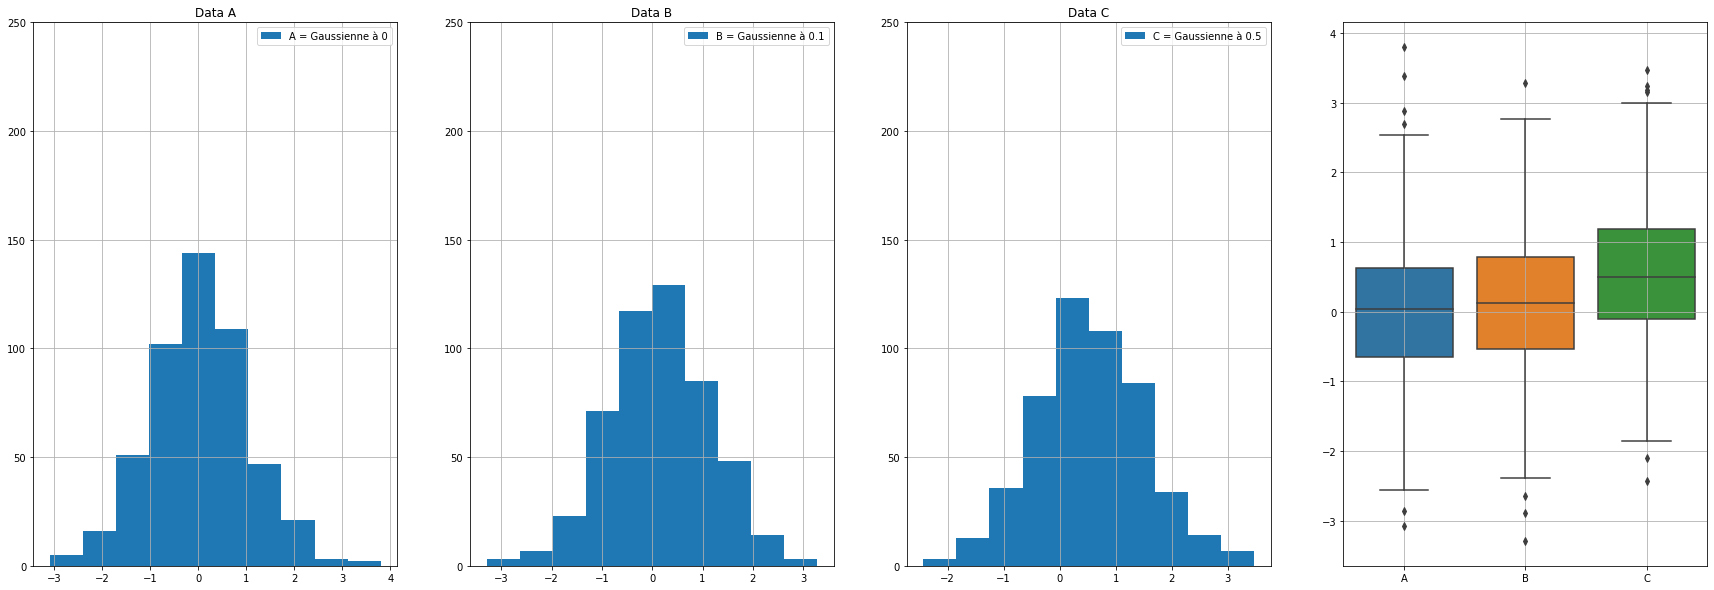

Mean A : 0.041676305078575525 
Mean B : 0.13836814933359268 
Mean C : 0.5489671231866772 
Variance A : 1.0028216148713662 
Variance B : 0.990982792294121 
Variance C : 0.9603943248361099


In [6]:
range_max = n / 2
nb_bins = 10

f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,4, 1)
ax = plt.hist(rvs1, bins = nb_bins, label = "A = Gaussienne à 0")
plt.title("Data A")
plt.ylim(0, range_max)
plt.grid()
plt.legend()
ax = f.add_subplot(1,4, 2)
ax = plt.hist(rvs2, bins = nb_bins, label = "B = Gaussienne à 0.1")
plt.title("Data B")
plt.ylim(0, range_max)
plt.grid()
plt.legend()
ax = f.add_subplot(1,4, 3)
ax = plt.hist(rvs3, bins = nb_bins, label = "C = Gaussienne à 0.5")
plt.title("Data C")
plt.ylim(0, range_max)
plt.grid()
plt.legend()

ax = f.add_subplot(1,4, 4)
df = pd.DataFrame(columns = ["A", "B"])
df["A"] = rvs1
df["B"] = rvs2
df["C"] = rvs3
ax = sns.boxplot(data=df)
plt.grid()
plt.show()

print("Mean A :", np.mean(rvs1), "\nMean B :", np.mean(rvs2), "\nMean C :", np.mean(rvs3),
      "\nVariance A :", np.var(rvs1), "\nVariance B :", np.var(rvs2), "\nVariance C :", np.var(rvs3))

## 4.2 Analyse statistique

### 4.2.a Test de Kolmogorov Smirnov (égalité des distributions)

In [7]:
print("A x B : ", stats.ks_2samp(rvs1, rvs2),
      "\nA x C : ", stats.ks_2samp(rvs1, rvs3),
      "\nB x C : ", stats.ks_2samp(rvs3, rvs2))

A x B :  KstestResult(statistic=0.064, pvalue=0.25760726053364696) 
A x C :  KstestResult(statistic=0.226, pvalue=1.3335106305083125e-11) 
B x C :  KstestResult(statistic=0.184, pvalue=8.2169644411341e-08)


### 4.2.b T test (égalité des moyennes)

In [8]:
print("A x B : ", stats.ttest_ind(rvs1, rvs2),
      "\nA x C : ", stats.ttest_ind(rvs1, rvs3),
      "\nB x C : ", stats.ttest_ind(rvs3, rvs2))

A x B :  Ttest_indResult(statistic=-1.5296738443983127, pvalue=0.12641436434013023) 
A x C :  Ttest_indResult(statistic=-8.08766657874048, pvalue=1.7530785839046194e-15) 
B x C :  Ttest_indResult(statistic=6.565949354256553, pvalue=8.301619036277058e-11)


## 4.3 Analyse topologique

### 4.3.a Premier score

In [9]:
print("A x B : ", score2(df[["A"]], df[["B"]]),
      "\nA x C : ", score2(df[["A"]], df[["C"]]),
      "\nB x C : ", score2(df[["B"]], df[["C"]]))

A x B :  0.8807977488313603 
A x C :  0.589811578270077 
B x C :  0.6409753923139141


### 4.3.a Second score

In [10]:
mean_AB = np.mean(df["A"].append(df["B"]))
mean_AC = np.mean(df["A"].append(df["C"]))
mean_BC = np.mean(df["B"].append(df["C"]))
std_A = np.std(df["A"])
std_B = np.std(df["B"])
std_C = np.std(df["C"])
A_ab = (df[["A"]] - mean_AB) * std_B / (std_A**2)
B_ab = (df[["B"]] - mean_AB) * std_A / (std_B**2)
A_ac = (df[["A"]] - mean_AC) * std_C / (std_A**2)
C_ac = (df[["C"]] - mean_AC) * std_A / (std_C**2)
B_bc = (df[["B"]] - mean_BC) * std_C / (std_B**2) 
C_bc = (df[["C"]] - mean_BC) * std_B / (std_C**2)

In [11]:
print("A x B : ", score2(A_ab, B_ab),
      "\nA x C : ", score2(A_ac, C_ac),
      "\nB x C : ", score2(B_bc, C_bc))

A x B :  0.8807984521008131 
A x C :  0.5879165821759764 
B x C :  0.6385101900349697


In [13]:
stats.shapiro(np.append(df["A"].values, 100))

ShapiroResult(statistic=0.12780821323394775, pvalue=8.435816755235399e-43)